## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [2]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import MNIST_data, Air_data, Syn_data
from model import OFL_Model
from utils import sigma_diff

K = 1000        # Number of clients
D = 34826       # number of parameters
P = 0.01        # Com. overhead reduction rate from FedOGD
L = 4           # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)
p2 = p * L
print(s, b, p, p2)

3 777 0.08615903990710687 0.3446361596284275


### 2. Experiment Setting

In [3]:
#MNIST
x_train, y_train, input_size = MNIST_data(iid=True, shuffle=False)
x_train_2, y_train_2, input_size = MNIST_data(False, False)
x_train_3, y_train_3, input_size = MNIST_data(False, True)
task = 'clf'

#Air
# x_train, y_train, input_size = Air_data()
# task = 'reg'

#Synthetic data
# x_train, y_train = pull_Syn_data('Syn', 0)
# task = ''

Model_list = []

Model_list.append(OFL_Model('FedOGD', task, K, [False, 0, 0], 1, 1, input_size))
Model_list.append(OFL_Model('FedOGD_2', task, K, [False, 0, 0], 1, 1, input_size))
Model_list.append(OFL_Model('FedOGD_3', task, K, [False, 0, 0], 1, 1, input_size))
# Model_list.append(OFL_Model('OFedAvg', task, K, [False, 0, 0], P, 1, input_size))
# Model_list.append(OFL_Model('OFedIQ', task, K, [True, s, b], p, 1, input_size))
# Model_list.append(OFL_Model('OFedIQ(L)', task, K, [True, s, b], p2, L, input_size))



2022-11-15 13:46:58.585258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Training

In [11]:
# for model in Model_list:
#     for iter in range(15):
#         for i in range(60):
#             model.train(x_train[K*i : K*(i+1)], y_train[K*i : K*(i+1)], (i+1) % model.L)
#         print(i, end =',')

model = Model_list[0]
for iter in range(10):
    for i in range(60):
        model.train(x_train[K*i : K*(i+1)], y_train[K*i : K*(i+1)], (i+1) % model.L)
    print(i, end =',')
print()

model = Model_list[1]
for iter in range(10):
    for i in range(60):
        model.train(x_train_2[K*i : K*(i+1)], y_train_2[K*i : K*(i+1)], (i+1) % model.L)
    print(i, end =',')
print()

model = Model_list[2]
for iter in range(10):
    for i in range(60):
        model.train(x_train_3[K*i : K*(i+1)], y_train_3[K*i : K*(i+1)], (i+1) % model.L)
    print(i, end =',')

result_list = []
for model in Model_list:
    result_list.append(model.pull_result())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

### 3. Save Result

In [5]:
import pickle

code = input("Code: ")

for i, model in enumerate(Model_list):
    name = model.name
    with open(f"./result/{task}_{name}_{code}.pkl","wb") as f:
        pickle.dump(result_list[i], f)

### 4. Plot Result

/var/folders/6h/r86dmwyj6ygczrnpndmvt1pr0000gp/T/ipykernel_19649/1442477019.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,0.1])


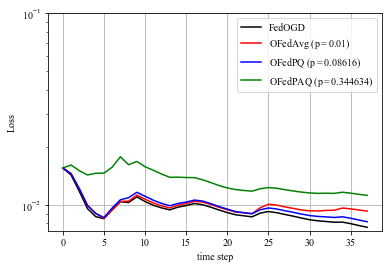

In [10]:
import matplotlib.pyplot  as plt

task = 'clf'
code = input('Code:')

with open(f"./result/{task}_FedOGD_{code}.pkl", "rb") as f:
    r1 = pickle.load(f)
with open(f"./result/{task}_OFedAvg_{code}.pkl", "rb") as f:
    r2 = pickle.load(f)
with open(f"./result/{task}_OFedIQ_{code}.pkl", "rb") as f:
    r3 = pickle.load(f)
with open(f"./result/{task}_OFedIQ(L)_{code}.pkl", "rb") as f:
    r4 = pickle.load(f)

l1 = list(range(len(r1))) 
l2 = list(range(len(r2)))
l3 = list(range(len(r3)))
l4 = list(range(len(r4)))

plt.plot(l1, r1, 'black', label=r'FedOGD')
plt.plot(l2, r2, 'red', label=r'OFedAvg ($\mathdefault{p=0.01}$)')
plt.plot(l3, r3, 'blue', label=r'OFedIQ ($\mathdefault{p=0.08616, L=1}$)')
plt.plot(l4, r4, 'green', label=r'OFedIQ ($\mathdefault{p=0.344634, L=4}$)')

plt.xlabel('time step')

if task == 'clf':
    plt.ylabel('Accuracy')
elif task == 'reg':
    plt.ylabel('Loss')
    plt.yscale("log")

plt.ylim([0,0.1])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/{task}_{code}_1.png', dpi=200, facecolor="white")
plt.show()

### 5. $\sigma_{\rm diff}$

In [16]:
x_train, y_train = MNIST_data()
sigma = sigma_diff(Model_list[0], x_train, y_train, 60)
print(sigma)

12.626342124166777


FedOGD w/ iid data: 7.069452932191554

FedOGD w/ non-iid data: 12.626342124166777